In [27]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import*
import scipy.optimize as opt
from tcsim.analyze.dataloader import*

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp2d

import numpy as np
import cvxpy as cp
import qutip as qt
from scipy.special import genlaguerre
from math import sqrt, factorial
import matplotlib.pyplot as plt
from scipy.linalg import lstsq, eigh, svd
from scipy.sparse.linalg import LinearOperator, lsqr
import h5py
from tqdm.auto import tqdm # progress bar
from matplotlib import colors
from tcsim.visualization import*
from tcsim.gates import*
from tcsim.system import*
from tcsim.analyze.dataloader import*
from tcsim.analyze.fit_funcs.char_func_fringe import char_func_fringe


In [35]:
def odd_cat(N,alpha):
    cat = (coherent(N,alpha) - coherent(N, -alpha)).unit()
    return cat

def vectorize(rho):
    """
    Turn hermitian matrix rho into a real vector
    vectorize(rho)[:d] = diag(rho)
    vectorize(rho)[d:d + d*(d-1)/2] = Re[upper_triangle(rho)]
    vectorize(rho)[d + d*(d-1)/2:]  = Im[upper_triangle(rho)]
    """
    d = rho.shape[0]  ## the shape of first column - dimension of matrix, e.g. 3x3 matrix d = 3
    n_offd = d*(d-1)//2 
    ret = np.zeros(d**2) #array of zeros with dimensionality d**2
    i = 0
    for m in range(d):
        ret[m] = rho[m, m].real #mth entry in ret is real part of (m,m) diagonal entry of matrix, capped at d
        for n in range(m+1, d):
            ret[d+i] = rho[m, n].real  #set d+ith entry in ret to real part of (m,n) off diagonal entry of matrix
            ret[d+n_offd+i] = rho[m, n].imag
            i += 1
    return ret


def matricize(rvec):
    """
    Invert the vectorize operation such that matricize(vectorize(rho)) == rho
    """
    d = int(np.sqrt(len(rvec)))
    n_offd = d*(d-1)//2
    ret = np.diag(rvec[:d]).astype(np.complex) # 将rvec[:d]转化为一个对角矩阵，并且用a+jb的形式表示
    i = 0
    for m in range(d):
        for n in range(m+1, d):
            real = rvec[d+i]
            imag = rvec[d+n_offd+i]
            val = real + 1j*imag
            ret[m, n] = val
            ret[n, m] = val.conj()
            i += 1
            
def char_ops(hilbert_size, betas):
    ops_list = []

    for beta in tqdm(betas):
        D = displace(100, beta) # need the larger Hilbert space to not get erroneous operators for large beta
        op = D
        op = Qobj(op[:hilbert_size, :hilbert_size]) # truncate to wanted Hilbert space size
        ops_list.append(op)

    return ops_list

def reconstruct_char_complex_convex(char, disps, dim):
    # construct vectors
    basis_vectors = []
    for i in range(dim):
        vector = fock(dim, i)
        basis_vectors.append(vector.full())

    # construct operators
    basis_dms = []
    for vector1 in basis_vectors:
        for vector2 in basis_vectors:
            dm = np.outer(vector2, vector1)
            basis_dms.append(dm)
    Pis = char_ops(dim, disps)
    A = np.zeros((len(Pis), dim*dim), dtype=complex)
    
    for index, a in tqdm(np.ndenumerate(A)):
        A[index] = np.trace(Pis[index[0]].full() @ basis_dms[index[1]])
    
    X = cp.Variable((dim,dim), hermitian=True)
    cost = cp.norm(A @ cp.reshape(X, (dim*dim)) - char, 2)
    constraints = [cp.trace(X) == 1, X >> 0]
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve()
    reconstructed_rho = Qobj(X.value)
    return reconstructed_rho

def make_disps(xmax, N):
    xs = np.linspace(-xmax, xmax, N)
    X, Y = np.meshgrid(xs, xs)
    return (X + Y*1j).flatten()

def reconstruct_dm(data,x, N):
    
    im = np.zeros((data.shape))
    data_with_im = data + 1j*im
    re_rho = reconstruct_char_complex_convex((data_with_im).flatten(),make_disps(np.max(x)*3,len(x)), N)
    rho = Qobj(re_rho)
    return rho


def line(x, m, y):
    return x*m+y

def find_angle(data, x, initial_guess =[0.8,  0.8, 1, 1, np.pi/2, 0], plot = False ):
    ### extract angle of cat
    scaling = 3
    xvec = x*scaling # i define it like this in case i want to slice x
    X, Y = np.meshgrid(xvec, xvec)

        
    popt, pcov = curve_fit(char_func_fringe, (X, Y), data.flatten(), p0=initial_guess, maxfev = 5000)
    angle = popt[4]

    if plot:
        data_fitted1 = char_func_fringe((X, Y), *popt)
        fig, ax = plt.subplots()
        ax.pcolormesh(X,Y, data, cmap="seismic", vmin = -1 , vmax = 1)
        ax.contour(yvec,xvec, data_fitted1.reshape(X.shape))
        ax.set_aspect("equal")
    return angle


def load_data_no_average(path: str, file_end: str,thresh, plot = True): 
    """_summary_

    Args:
        path (str): folder where files are located
        file_end (str): ending of files to load
        
    Returns:
        dd (dict): keys are time stamps and value is a non averaged data set of size (number of total reps, x, y)
    """
    fps = []
    fp = [path + f for f in os.listdir(path) if f.endswith(file_end)]
    fps = np.concatenate([fp[:]])
    
    dg = []
    de = []
    dts = []
    for kk in range(len(fps)):
        df = h5py.File(fps[kk], "r")
        data = df["data"]
        data_i = data["I"][:]
        x = data["x"][:, 0, 0]
        y = data["y"][0, :, 0]
        dt = df.attrs['decay_time']
#         ss_data = np.where(data_i < thresh, 1, 0)
#         thresh_1 = 6.30337300715842e-05
        raw_m0 = data_i[:, 0::3]
        raw_m1 = data_i[:, 1::3] 
        raw_m2 = data_i[:, 2::3]
        
        m0 = np.where(raw_m0 < thresh, 1, 0)
        m1 = np.where(raw_m1 < thresh, 1, 0)
        m2 = np.where(raw_m2 < thresh, 1, 0)
        
        m1_g = ma.masked_array(m1, mask=m0)
        m2_g = ma.masked_array(m2, mask=m0)
        ## I only care about the double selected data!
        ## I use filled to replace all masked arrays with nan. This allows me to not care about masks after this point. This is useful, as i can later use np.nanmean to calculate the mean value.
        double_ps_g = ma.masked_array(m2_g, mask=m1_g, dtype='float').filled(np.nan).reshape(df.attrs["reps"],len(x), len(y)) * 2 - 1
        double_ps_e = ma.masked_array(m2_g, mask=np.logical_not(m1_g), dtype='float').filled(np.nan).reshape(df.attrs["reps"], len(x), len(y)) * 2 - 1
        dg.append(double_ps_g)
        de.append(double_ps_e)
        dts.append(dt)

    dg = np.array(dg)
    de = np.array(de)
    dts = np.array(dts)
    decay_times = np.unique(dts)

    
    dd = {}
    # initialize a dictionary with decay times as keys
    for n in range(len(decay_times)):
            dd[str(decay_times[n])] = []

    # use dts to sort the values by decay time into the correct bin
    for n, dt in enumerate(dts):
        dd[str(dt)].append(dg[n])
      
    # stack all arrays that were in the list
    for dt in decay_times:
        dd[str(dt)] = np.vstack(np.array(dd[str(dt)]))
    
    fig, axes = plt.subplots( figsize=(16, 12))
    # for i in range(rows):
    
    axes.pcolormesh(x, x, np.nanmean(dd[str(decay_times[0])][:, :], axis = 0), cmap="seismic", shading = 'auto', vmax=1, vmin=-1)
    axes.set_aspect("equal")
         
    plt.show()
    return dd, decay_times, x, y 
    
def bootstrap_resample(X):
    n = shape(X)[0]
    X_resample = np.zeros_like(X.T)
    XT = X.T.copy()

    resample_i = np.floor(np.random.rand(n)*n).astype(int)
    for x in range(shape(X)[1]):
        for y in range(shape(X)[2]):
                      
                X_resample[:][y][x] = XT[y][x][resample_i]
    return X_resample.T

def dm_reconstruct_fid_bootstrap(data, x, n_reps, N):
    rhos = []
    
    for rep in range(n_reps):
        ### 0. resample data and saved resampled data in new dictionary
        data_bt = bootstrap_resample(data)
        data_norm_average = np.nanmean(data_bt, axis=0)
        rho = reconstruct_dm(data_norm_average, x, N)
        rhos.append(rho)
    return rhos

def sq7_cat(N,alpha):
    uv = [-0.83900019,  0.56644014,  1.2973754 , -0.59798946, -1.26378237,
        0.38608659]
    sq7_tensor = squeezingStateThreeStep(uv)
    sq7 = ptrace(sq7_tensor,1).unit()
    cat = ((displace(N,1j*alpha) - displace(N, -1j*alpha))*sq7*((displace(N,1j*alpha) - displace(N, -1j*alpha))).dag()).unit()
    return cat
    

### normal cat

1


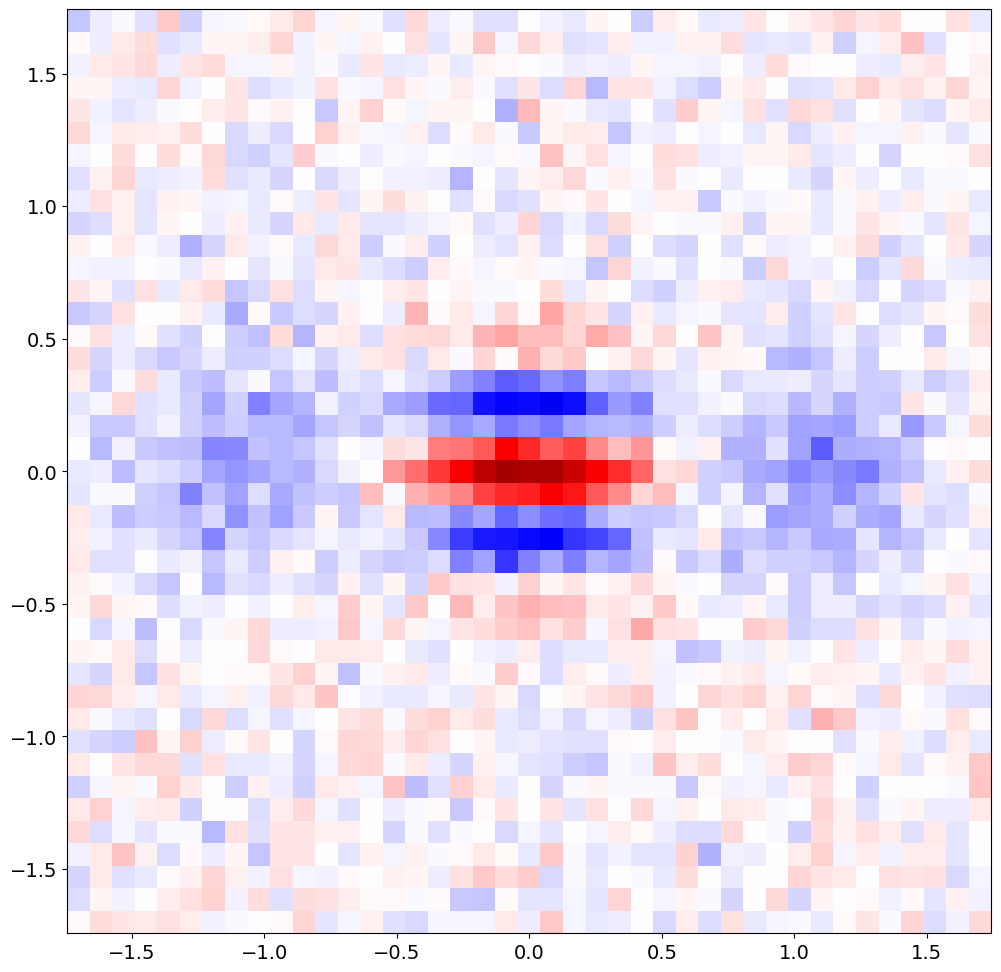

100%|██████████| 1681/1681 [00:15<00:00, 112.02it/s]
672400it [00:09, 70338.75it/s]
100%|██████████| 1681/1681 [00:15<00:00, 109.61it/s]
672400it [00:09, 67876.30it/s]
100%|██████████| 1681/1681 [00:14<00:00, 113.02it/s]
672400it [00:10, 67027.29it/s]
100%|██████████| 1681/1681 [00:14<00:00, 114.58it/s]
672400it [00:09, 72019.18it/s]
100%|██████████| 1681/1681 [00:14<00:00, 116.06it/s]
672400it [00:09, 73162.70it/s]
100%|██████████| 1681/1681 [00:14<00:00, 114.20it/s]
672400it [00:09, 71471.85it/s]
100%|██████████| 1681/1681 [00:14<00:00, 113.84it/s]
672400it [00:09, 72844.57it/s]
100%|██████████| 1681/1681 [00:14<00:00, 115.77it/s]
672400it [00:09, 71750.33it/s]
100%|██████████| 1681/1681 [00:14<00:00, 116.67it/s]
672400it [00:09, 71820.47it/s]
100%|██████████| 1681/1681 [00:14<00:00, 115.70it/s]
672400it [00:09, 71094.50it/s]
100%|██████████| 1681/1681 [00:14<00:00, 115.95it/s]
672400it [00:09, 71389.03it/s]
100%|██████████| 1681/1681 [00:14<00:00, 115.39it/s]
672400it [00:09, 72145.

0.540339774931359
0.005817985979618735
2


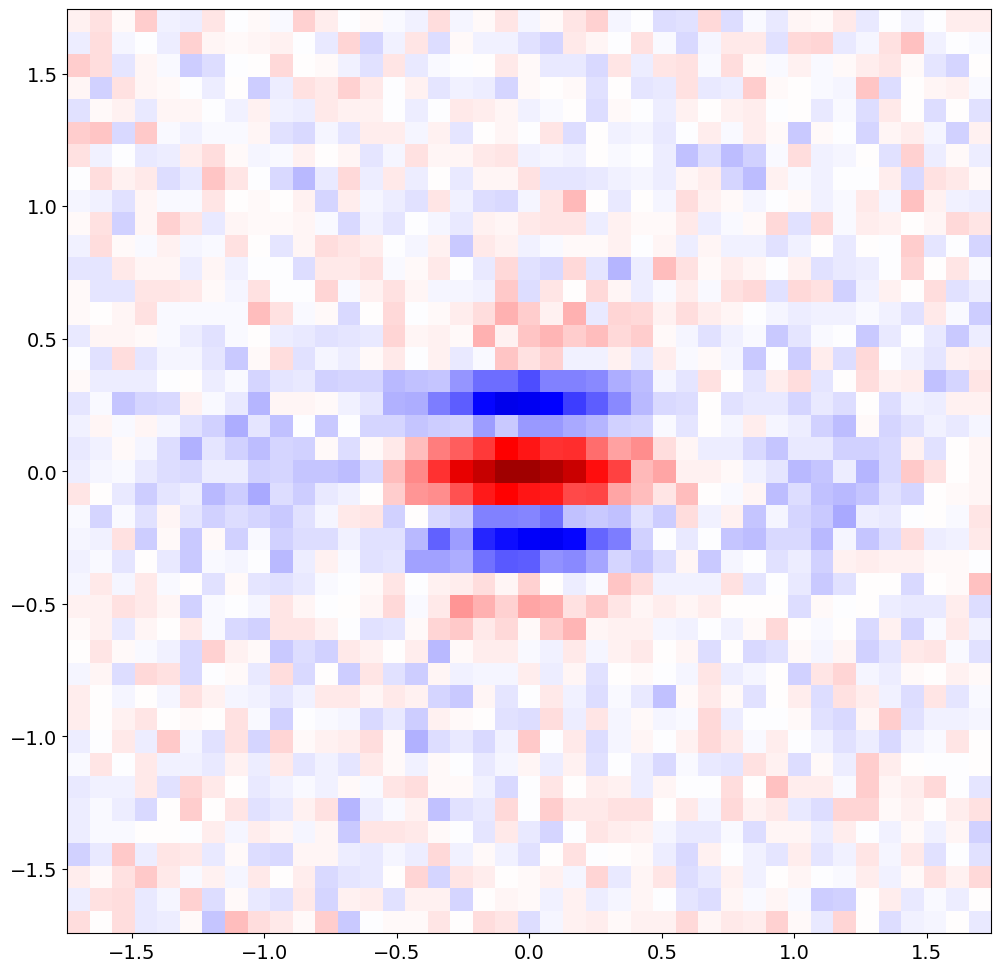

100%|██████████| 1681/1681 [00:14<00:00, 114.77it/s]
672400it [00:09, 71900.80it/s]
100%|██████████| 1681/1681 [00:14<00:00, 116.03it/s]
672400it [00:09, 72203.14it/s]
100%|██████████| 1681/1681 [00:14<00:00, 114.93it/s]
672400it [00:09, 72145.05it/s]
100%|██████████| 1681/1681 [00:14<00:00, 114.56it/s]
672400it [00:09, 71528.32it/s]
100%|██████████| 1681/1681 [00:14<00:00, 115.04it/s]
672400it [00:09, 72404.01it/s]
100%|██████████| 1681/1681 [00:14<00:00, 115.51it/s]
672400it [00:09, 72193.76it/s]
100%|██████████| 1681/1681 [00:14<00:00, 115.22it/s]
672400it [00:09, 70349.78it/s]
100%|██████████| 1681/1681 [00:14<00:00, 115.71it/s]
672400it [00:09, 70839.44it/s]
100%|██████████| 1681/1681 [00:14<00:00, 115.24it/s]
672400it [00:09, 71704.30it/s]
100%|██████████| 1681/1681 [00:14<00:00, 115.88it/s]
672400it [00:09, 71818.82it/s]
100%|██████████| 1681/1681 [00:14<00:00, 113.84it/s]
672400it [00:09, 71625.50it/s]
100%|██████████| 1681/1681 [00:14<00:00, 115.22it/s]
672400it [00:09, 71684.

0.4494070551526401
0.007373374467039225
3


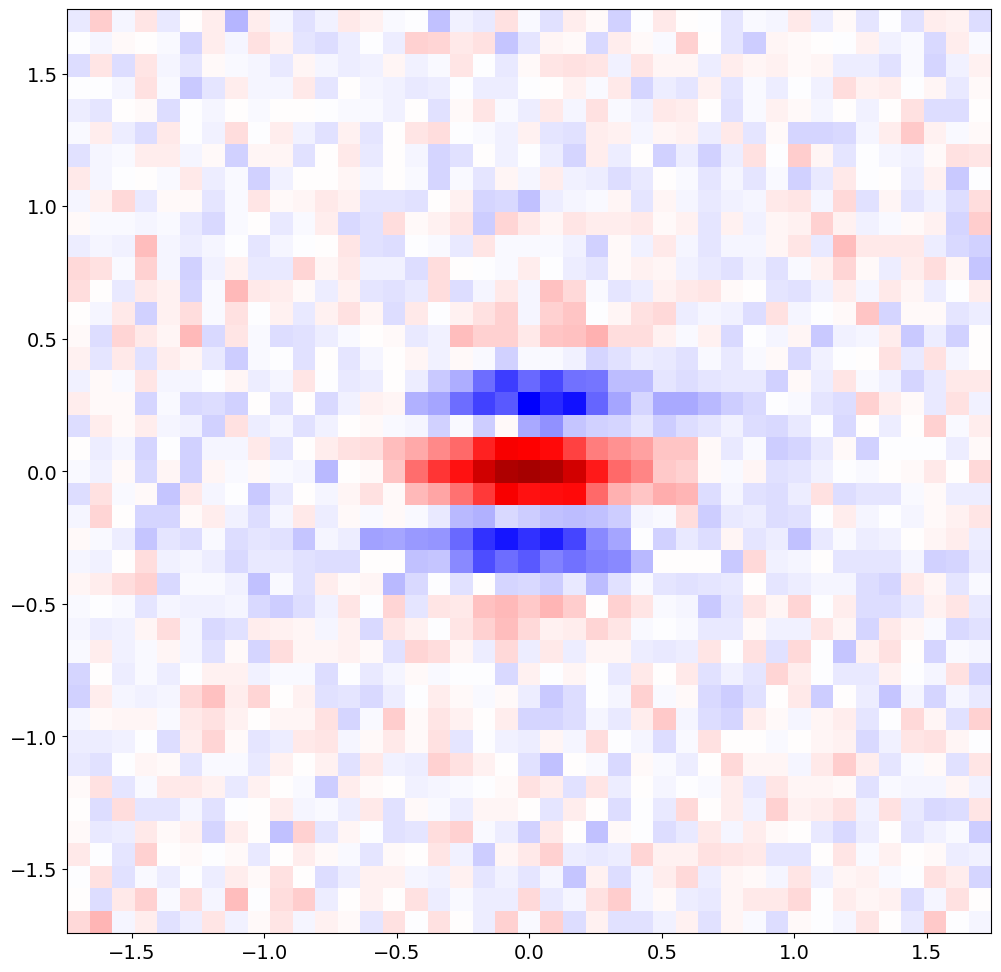

100%|██████████| 1681/1681 [00:14<00:00, 115.42it/s]
672400it [00:09, 71725.03it/s]
100%|██████████| 1681/1681 [00:14<00:00, 115.06it/s]
672400it [00:09, 72532.34it/s]
100%|██████████| 1681/1681 [00:14<00:00, 115.74it/s]
672400it [00:09, 71988.80it/s]
100%|██████████| 1681/1681 [00:14<00:00, 114.74it/s]
672400it [00:09, 72064.49it/s]
100%|██████████| 1681/1681 [00:14<00:00, 115.37it/s]
672400it [00:09, 73152.22it/s]
100%|██████████| 1681/1681 [00:14<00:00, 114.40it/s]
672400it [00:09, 71581.28it/s]
100%|██████████| 1681/1681 [00:14<00:00, 115.14it/s]
672400it [00:09, 72331.40it/s]
100%|██████████| 1681/1681 [00:14<00:00, 113.98it/s]
672400it [00:09, 71919.31it/s]
100%|██████████| 1681/1681 [00:14<00:00, 114.80it/s]
672400it [00:09, 71601.74it/s]
100%|██████████| 1681/1681 [00:14<00:00, 114.69it/s]
672400it [00:09, 71242.31it/s]
100%|██████████| 1681/1681 [00:14<00:00, 115.27it/s]
672400it [00:09, 71690.21it/s]
100%|██████████| 1681/1681 [00:14<00:00, 114.54it/s]
672400it [00:09, 72071.

0.3940112103330098
0.007348799016158872


In [40]:
# normal cats
vac_norm = 0.884
filename = 'panther_normal_cat_decay_loop.h5' 

d = ["C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/fig4/normal_1/", "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/fig4/normal_20/", "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/fig4/normal_50/", "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/fig4/normal_100/"]
thresholds = [0.00018141837229237925 , 0.0002647792569571347, 0.0002112439539132786, 0.00019462099330314037
]
for i in [1,2,3]:
    print(i)
    data, dec, x, y = load_data_no_average(d[i],filename, thresh = thresholds[i], plot = True)

    data_norm =list(data.values())[0]/vac_norm
    rhos = dm_reconstruct_fid_bootstrap(data_norm, x, 25, 20)
    overlap = []
    for rho in rhos:
        cat = odd_cat(20, 1.77)
        overlap.append(expect(rho, cat))

    print(np.mean(overlap))
    print(np.std(overlap))

In [45]:
N = 20
a = qt.tensor(Iq, qt.destroy(N))
Ic = qt.qeye(N)
Iq = qt.qeye(2)

# Projectors
proj_g = qt.tensor(qt.fock(2,0)*qt.fock(2,0).dag(), Ic)
proj_e = qt.tensor(qt.fock(2,1)*qt.fock(2,1).dag(), Ic)

# Qubit Operators
sx = qt.tensor(qt.sigmax(), Ic)
sy = qt.tensor(qt.sigmay(), Ic)
sz = qt.tensor(qt.sigmaz(), Ic)
vac = qt.tensor(qt.fock(2,0),qt.fock(N,0))

def Rx(theta):
    return qt.tensor(rx(theta), Ic)
def Ry(theta):
    return qt.tensor(ry(theta), Ic)
def Rz(theta):
    return qt.tensor(rz(theta), Ic)

def U_ideal_operator(u_k):
    P = (1j*(a.dag()-a))/2
    Uk = (1j*u_k*P*sx).expm()
    return Uk

def V_ideal_operator(v_k):
    X = (a.dag()+a)/2
    Vk = (1j*v_k*X*sy).expm()
    return Vk

def squeezingStateThreeStep(uvs):
    u_1 = uvs[0]
    v_1 = uvs[1]
    u_2 = uvs[2]
    v_2 = uvs[3]
    u_3 = uvs[4]
    v_3 = uvs[5]

    psi1 = V_ideal_operator(v_1)*U_ideal_operator(u_1)*vac
    psi2 = V_ideal_operator(v_2)*U_ideal_operator(u_2)*psi1
    psi3 = V_ideal_operator(v_3)*U_ideal_operator(u_3)*psi2
 
    return psi3

# create theoretical states

def sq7_cat(N,alpha):
    uv = [-0.83900019,  0.56644014,  1.2973754 , -0.59798946, -1.26378237,
        0.38608659]
    sq7_tensor = squeezingStateThreeStep(uv)
    sq7 = ptrace(sq7_tensor,1).unit()
    cat = ((displace(N,1j*alpha) - displace(N, -1j*alpha))*sq7*((displace(N,1j*alpha) - displace(N, -1j*alpha))).dag()).unit()
    return cat

## 7.6 db cat

2


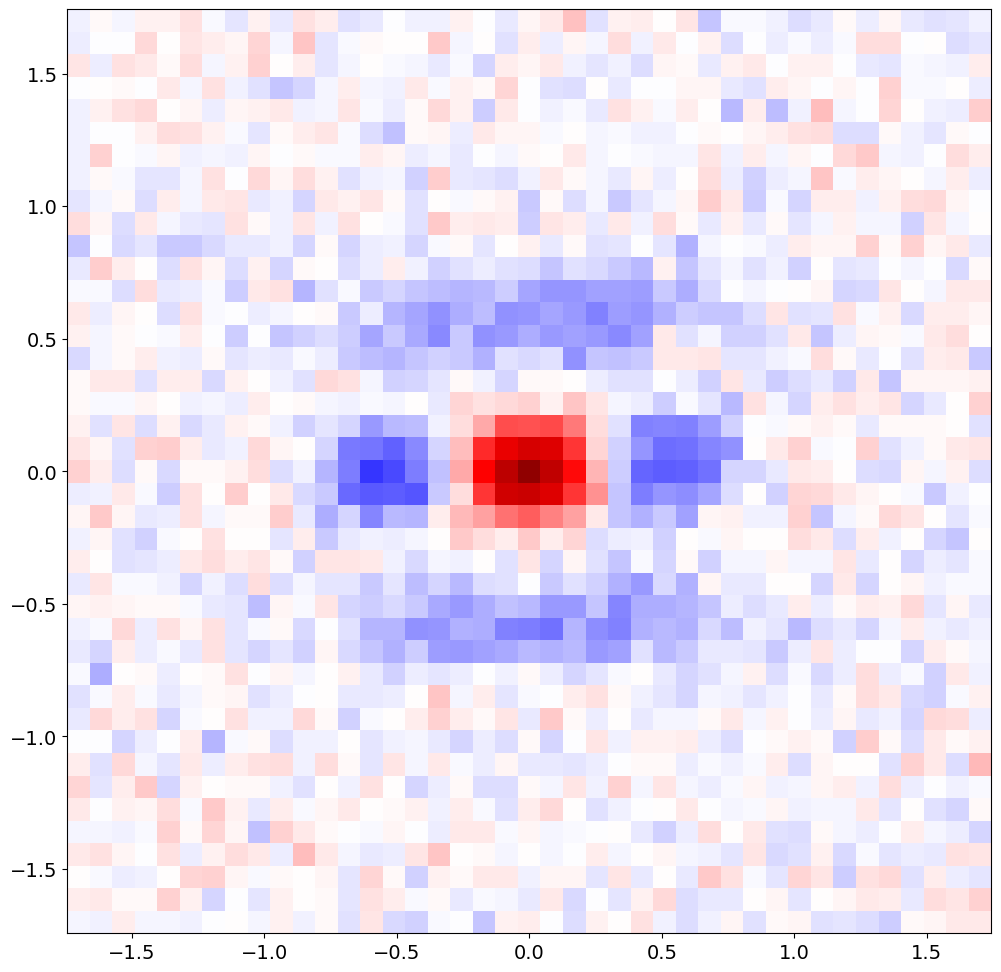

100%|██████████| 1681/1681 [00:15<00:00, 106.30it/s]
672400it [00:09, 71640.04it/s]
100%|██████████| 1681/1681 [00:14<00:00, 114.22it/s]
672400it [00:09, 69939.81it/s]
100%|██████████| 1681/1681 [00:14<00:00, 112.94it/s]
672400it [00:09, 70869.81it/s]
100%|██████████| 1681/1681 [00:16<00:00, 103.28it/s]
672400it [00:11, 59250.93it/s]
100%|██████████| 1681/1681 [00:16<00:00, 103.91it/s]
672400it [00:10, 64121.82it/s]
100%|██████████| 1681/1681 [00:15<00:00, 107.44it/s]
672400it [00:10, 65165.70it/s]
100%|██████████| 1681/1681 [00:17<00:00, 95.30it/s] 
672400it [00:10, 65117.45it/s]
100%|██████████| 1681/1681 [00:15<00:00, 106.67it/s]
672400it [00:10, 61480.80it/s]
100%|██████████| 1681/1681 [00:17<00:00, 97.39it/s] 
672400it [00:10, 65031.88it/s]
100%|██████████| 1681/1681 [00:16<00:00, 99.27it/s] 
672400it [00:10, 64913.88it/s]
100%|██████████| 1681/1681 [00:16<00:00, 100.78it/s]
672400it [00:09, 67901.98it/s]
100%|██████████| 1681/1681 [00:16<00:00, 103.40it/s]
672400it [00:12, 51959.

0.49588489801936175
0.006351052856230694
3


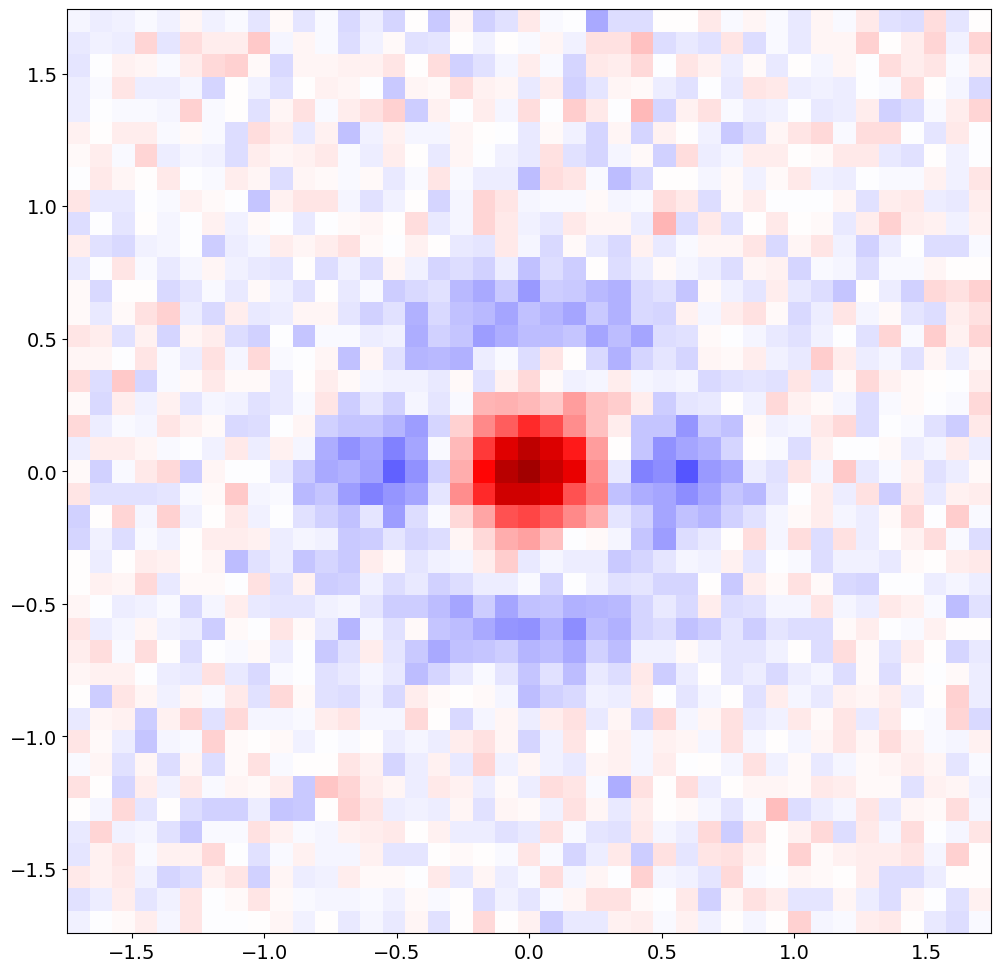

100%|██████████| 1681/1681 [00:14<00:00, 113.25it/s]
672400it [00:09, 70373.56it/s]
100%|██████████| 1681/1681 [00:14<00:00, 113.52it/s]
672400it [00:09, 70974.46it/s]
100%|██████████| 1681/1681 [00:14<00:00, 113.76it/s]
672400it [00:09, 70127.19it/s]
100%|██████████| 1681/1681 [00:15<00:00, 110.42it/s]
672400it [00:09, 68425.50it/s]
100%|██████████| 1681/1681 [00:15<00:00, 105.26it/s]
672400it [00:10, 65054.47it/s]
100%|██████████| 1681/1681 [00:14<00:00, 113.71it/s]
672400it [00:10, 65127.79it/s]
100%|██████████| 1681/1681 [00:16<00:00, 103.30it/s]
672400it [00:10, 62707.10it/s]
100%|██████████| 1681/1681 [00:16<00:00, 102.06it/s]
672400it [00:11, 58786.03it/s]
100%|██████████| 1681/1681 [00:17<00:00, 95.60it/s] 
672400it [00:10, 63950.07it/s]
100%|██████████| 1681/1681 [00:16<00:00, 102.58it/s]
672400it [00:10, 65054.49it/s]
100%|██████████| 1681/1681 [00:16<00:00, 103.48it/s]
672400it [00:10, 65377.14it/s]
100%|██████████| 1681/1681 [00:16<00:00, 103.38it/s]
672400it [00:10, 64813.

0.42043927450316254
0.004676506411569937


In [56]:
# normal cats
vac_norm = 0.883
filename = 'sq_vcat_7db_oddcat.h5' 

d = ["C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/fig4/7db_oddcat_1/", "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/fig4/7db_oddcat_20/", "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/fig4/7db_oddcat_50/", "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/fig4/7db_oddcat_100/"]
thresholds = [0.00020141837229237925 , 0.0001947792569571347, 0.0001952439539132786, 0.00020462099330314037
]
for i in [2,3]:
    print(i)
    data, dec, x, y = load_data_no_average(d[i],filename, thresh = thresholds[i], plot = True)

    data_norm =list(data.values())[0]/vac_norm
    rhos = dm_reconstruct_fid_bootstrap(data_norm, x, 25, 20)
    overlap = []
    for rho in rhos:
        cat = sq7_cat(20, 0.85)
        overlap.append(expect(rho, cat))

    print(np.mean(overlap))
    print(np.std(overlap))

In [60]:
cat = tensor(fock(2,0),odd_cat(20,2))

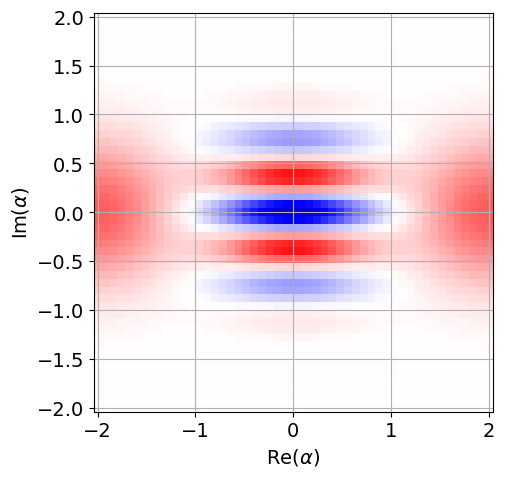

In [61]:
plot_wigner(cat)

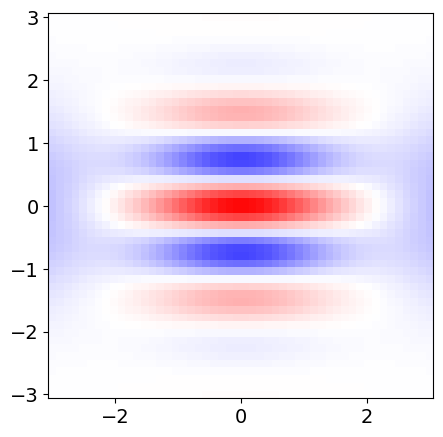

In [62]:
plot_char(cat)